In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(abspath('../../data/MSFT/MSFT.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(2502, 1)


Date,Open
2012-03-01,31.930000
2012-03-02,32.310001
2012-03-05,32.009998
2012-03-06,31.540001
2012-03-07,31.670000


In [4]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

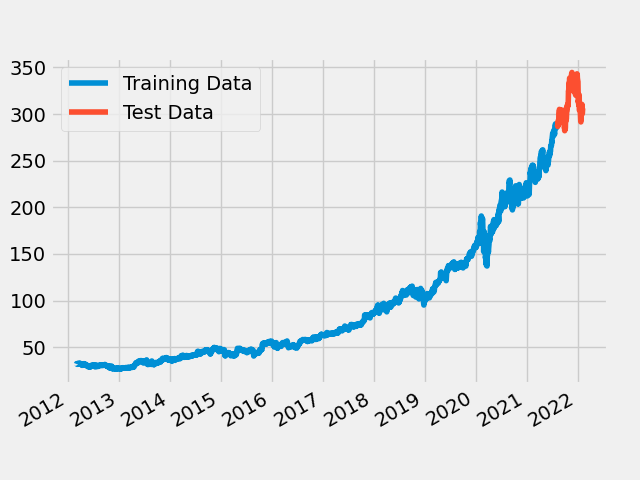

In [5]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [7]:
import tensorflow as tf

#List attached GPU devices
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # type: ignore

n_input = 60

train_generator=TimeseriesGenerator(train_scaled,
                                     train_scaled,
                                      length=n_input,
                                      batch_size=32)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
        
#Add first LSTM layer
model.add(LSTM(units=10, input_shape=(n_input, n_features)))
model.add(Dense(units=1))
model.summary()

Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-02-26 22:15:48.020062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 22:15:48.020784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-26 22:15:48.021229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Create an EarlyStopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [11]:
from CustomAdam import CustomAdam

model.compile(optimizer=CustomAdam(), loss='mean_squared_error')
model.fit(train_generator, epochs=25, callbacks=[early_stopping])

Epoch 1/25
73/73 [==============================] - 23s 163ms/step - loss: 0.0287
Epoch 2/25
73/73 [==============================] - 11s 155ms/step - loss: 0.0063
Epoch 3/25
73/73 [==============================] - 12s 161ms/step - loss: 5.9539e-04
Epoch 4/25
73/73 [==============================] - 12s 157ms/step - loss: 1.2248e-04
Epoch 5/25
73/73 [==============================] - 12s 158ms/step - loss: 1.2613e-04
Epoch 6/25
73/73 [==============================] - 11s 157ms/step - loss: 1.2214e-04
Epoch 7/25
73/73 [==============================] - 12s 166ms/step - loss: 1.1270e-04
Epoch 8/25
73/73 [==============================] - 12s 158ms/step - loss: 1.1721e-04
Epoch 9/25
73/73 [==============================] - 12s 160ms/step - loss: 1.0603e-04
Epoch 10/25
73/73 [==============================] - 12s 158ms/step - loss: 1.0154e-04
Epoch 11/25
73/73 [==============================] - 11s 157ms/step - loss: 9.9561e-05
Epoch 12/25
73/73 [==============================] - 12s 163

In [12]:
model.save('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-LSTM.h5')

In [13]:
test_generator=TimeseriesGenerator(test_scaled,
                                     test_scaled,
                                      length=n_input,
                                      batch_size=32)

In [14]:
# # method to check if a file exists
# def file_exists(file_path):
#     import os
#     return os.path.isfile(file_path)

# from keras.models import load_model

# if (file_exists('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')):
#     model = load_model('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')
# else:
#     print("File does not exist")

In [15]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

In [16]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(126, 60, 1)


In [17]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

In [18]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(126, 1)


,Open
Date,
2021-08-10,288.379120
2021-08-11,288.632050
2021-08-12,288.154541
2021-08-13,287.604706
2021-08-16,288.347839


<AxesSubplot:xlabel='Date'>

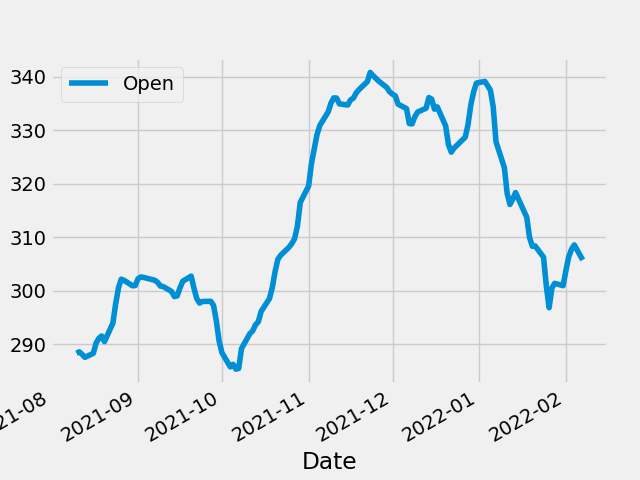

In [19]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

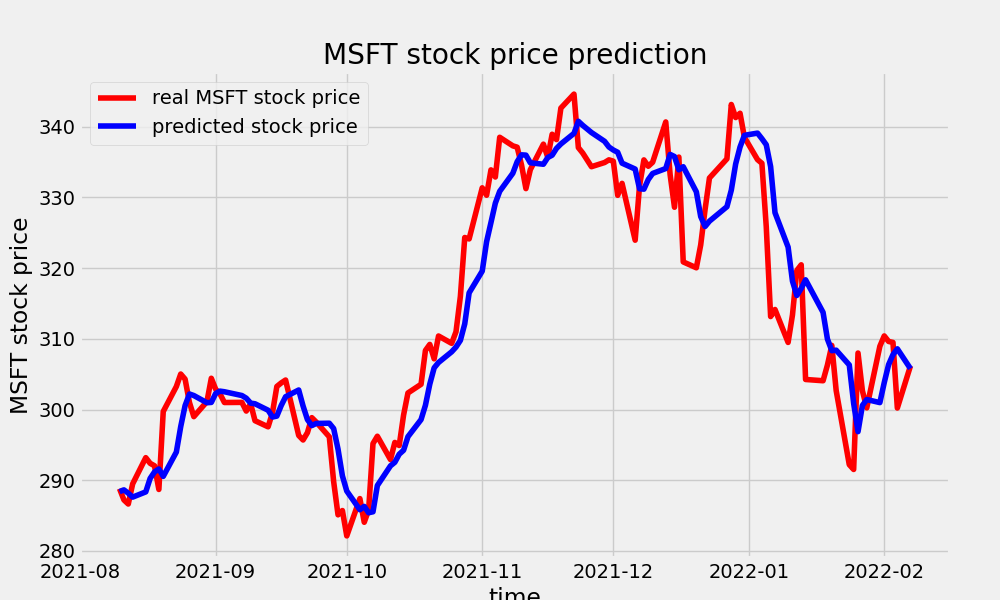

In [20]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [21]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

return_rmse(test_set, predicted)

the root mean squared error is : 6.045893441785353.
